## Proportional Control

If you wanted to build a robot that could follow a wall using an ultrasonic sensor, you might code it to use proportional control. This type of control algorithm uses a reading from your sensor, and a setpoint (or target distance) and reacts *proportionally* to the error between your reading and target. 

The algorithmic flow of proportional control is best described by this image: 

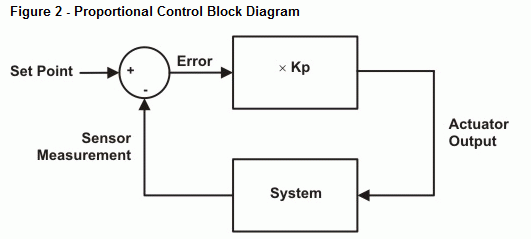

If this confuses you, that's ok. You will no doubt understand it by the end of this project!

Run the initialization script below to get started. 

In [ ]:
'''----------------------------------------------------------'''
'''Run this before anything else!!!'''
'''----------------------------------------------------------'''

##IMPORTS##
from easygopigo3 import EasyGoPiGo3
from EDL_Jupyter_resources import HiddenPrints
from IPython.display import clear_output
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
hiddenprints=HiddenPrints()

# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()

###SENSORS###
my_distance_sensor=easyGPG.init_distance_sensor()

###INITIALIZING VARIABLES & CONSTANTS###
sample_rate=60 #samples/sec for US sensor
target=20 #drive to 20cm
length=20 #max length of loop is 20 seconds

def telemetry_report(telemetry,target,sample_rate):
    '''This function makes pretty graphs that 
    you can use to visually analyze your data'''
    
    if len(telemetry[0])>2: #graph P signal or no?
        P_exist=True
    else:
        P_exist=False
        
    pos=[] #data lists
    err=[]
    parry=[]
    x=[]
    for i in range(len(telemetry)): #populate lists
        #position and error data
        pos.append(telemetry[i][0])
        err.append(telemetry[i][1])
        if P_exist:
            #PID data
            parry.append(telemetry[i][2])
        #x-axis
        x.append(i/sample_rate) #x value is time

    target_array=np.empty(len(x)) #for making the target line
    target_array.fill(target)

    plt.figure(0)
    plt.title('Position vs Time & Target Line')
    plt.plot(x,pos) #plot pos vs time
    plt.plot(x,target_array) #plot the target line
    plt.figure(1)
    if P_exist:
        plt.title('Error / P Signal vs Time')
        plt.plot(x,err) #plot the error vs time
        plt.plot(x,parry) #plot pid stats vs time
    else:
        plt.title('Error vs Time')
        plt.plot(x,err) #plot the error vs time
    plt.show()

print('Initialized.')

### Basic example

To show the power of proportional control, lets try to code a script that makes GoPiGo drive at full speed towards a wall until it reads that it is 20 cm away, at which point it should stop immidiately.

Put your GoPiGo more than 20cm away from a wall, with the distance sensor mounted to the front. Finish and run the code below and look at the resulting graphs. 



In [ ]:
#Proportional Control Drive to Wall & Stop No P Exercise

###DATA ARRAYS###
raw_data=np.array([]) #this will be our running list of distance data
telemetry=[] #telemetry

'''----------------------------------------------------------'''
max_speed=1000 #Can be anywhere between 0 and 1000
'''----------------------------------------------------------'''

###PRE LOOP TASKS###
easyGPG.stop()  #stop the car if its running
easyGPG.set_speed(max_speed) #Here we set the speed. 

###LOOP###
easyGPG.forward() #begin to drive forward
start=time.time() #start the clock 
while time.time()-start<length: #run
    
    reading=my_distance_sensor.read() #this is our reading
    raw_data=np.append(raw_data,reading) #this is our data set
    
    '''----------------------------------------------------------'''
    '''
    In the space below:
    
    -Create a variable called error, that is the current reading minus the target distance.
    -If error is less than one, break out of the loop.
    
    '''
    #define error here
    error=reading-target #answer
    
    telemetry.append([reading,error]) #Don't change this
    
    #write your if statement here
    if error<1: #answer
        break
    
    '''----------------------------------------------------------'''
    
    time.sleep(1/sample_rate)

print('Loop has finished. Stopping Car.')
print('Final error was %d'%error)
    
easyGPG.stop() #stop the car

telemetry_report(telemetry,target,sample_rate)

### Improving our final error

After looking at the output of the code above, why do you think your final error might not have been zero? Lower the max_speed variable under the constants section of the code. Does this improve your final error? What value of max_speed gives you no error at the end?

It's great to be accurate, but by improving your final error, you probably reduced max_speed down to a relatively low value. What if the GoPiGo could drive at 1000 speed when it was far away from 20cm, but slow down as it got closer to 20cm? This is the concept behind proportional control. 

### Slowing down as we get close: Proportional Control

To make our speed change as we get closer, we will adjust our percent of maximum speed using the easyGPG.steer(L,R) function, where L & R are percent values between -100 and 100. If we have max_speed 1000, and we run easyGPG.steer(50,50), we will actually drive at speed 500. 

Now, we just need to adjust our steering percentage by a proportion of how close we are, or, our *error*. Write a function called *P_control* that takes in a constant integer called *kp* and an *error* value, and returns *P*, where 
```
P=kp*error
```

In the main loop, steer the GoPiGo using P_control of the error. 


In [ ]:
#Proportional Control Drive to Wall Exercise

###INITIALIZING VARIABLES###
raw_data=np.array([]) #this will be our running list of distance data
telemetry=[] #debugging

'''----------------------------------------------------------'''
max_speed=1000 #maximum speed of motors 
kp=2 #Can be anything you want. This is percent speed reaction to 1 cm of error. 
'''----------------------------------------------------------'''

###PRE LOOP TASKS###
easyGPG.stop()  #stop the car if its running
easyGPG.set_speed(max_speed) #Here we set the speed. 

##FUNCTIONS##
'''----------------------------------------------------------'''
''' Define your function P_control here'''
def P_control(kp,error):
    '''Return the difference between
    where we are and where we want to be
    multiplied by derivative constant'''
    return(kp*error)
'''----------------------------------------------------------'''

###LOOP###
start=time.time() #start the clock 
while time.time()-start<length: #run

    reading=my_distance_sensor.read()
    raw_data=np.append(raw_data,reading)
    
    '''----------------------------------------------------------'''
    '''
    In the space below:
    
    -Define error as you did in the previous section
    -Save a variable P as the result of P_control(kp, error)
    -Use easyGPG.steer(L,R) to steer the robot using the control variable P
    -When abs(error) is less than one, just like last time, stop the robot. 
    
    '''
    error=reading-target #answer
    
    P=P_control(kp,error) #answer
    
    L=P
    R=P #steer the robot #answer
    easyGPG.steer(L,R)
    
    telemetry.append([reading,error,P]) #Don't change this
    
    if abs(error)<1: #answer
        break 
        
    '''----------------------------------------------------------'''
    
    time.sleep(1/sample_rate)
    

print('Loop has finished. Stopping Car.')
print('Final error was %d'%error)
    
easyGPG.stop() #stop the car

telemetry_report(telemetry,target,sample_rate)

Look at the resulting graphs. Did you get an error of zero? If not, try lowering kp to slow down the car more as you approach an error of zero. You should notice the GoPiGo slow down as it gets close to 20cm. 

Notice how the error graph includes a new line, called P Signal. This is the percent value that is being sent to the motors (if it is > 100, GPG just sets it back to 100). It should change proportionally based on the error signal, with a ratio of kp. As the error gets close to zero, the P Signal also gets smaller, slowing the GPG down. This is proportional control.

### Left-hand wall following using proportional control

If we place the distance sensor on the left side of the robot, and place the robot perpendicular to a wall, we should be able to follow the wall by reading the distance from the wall, and steering proportionally based on our error. 

Adjust the code below so that when P=0, it drives forward with a default speed of 50%. Then, choose to either add or subtract P from the L and R variables, so that when the error gets larger, it steers left. Think about which motor needs to drive faster in order to steer left. Change *target* to be:

```
target=my_distance_sensor.read()
```

so that the robot just follows the wall, instead of trying to get closer or farther away from it. It should run for 20 seconds by default, and the default speed is reduced. 

Can you get your robot to follow a wall? Interpret your telemetry graphs and change kp until it does it successfully. 

In [ ]:
#Proportional Control Wall Following Exercise

###INITIALIZING VARIABLES###
raw_data=np.array([]) #this will be our running list of distance data
telemetry=[] #debugging

###CONSTANTS###
max_speed=300

'''----------------------------------------------------------'''
kp=5 #Can be anything you want. This is percent speed reaction to 1 cm of error. 

#Update target here to be the first distance reading!
target=my_distance_sensor.read() #we want to follow the wall
'''----------------------------------------------------------'''

###PRE LOOP TASKS###
easyGPG.stop()  #stop the car if its running
easyGPG.set_speed(max_speed) #Here we set the speed. 

##FUNCTIONS##
'''----------------------------------------------------------'''
''' Define your function P_control here'''
def P_control(kp,error):
    '''Return the difference between
    where we are and where we want to be
    multiplied by derivative constant'''
    return(kp*error)
'''----------------------------------------------------------'''

###LOOP###
start=time.time() #start the clock 
while time.time()-start<length: #run

    reading=my_distance_sensor.read()
    raw_data=np.append(raw_data,reading)
    
    '''----------------------------------------------------------'''
    '''
    In the space below:
    
    -Define error as you did in the previous section
    -Save a variable P as the result of P_control(kp, error)
    -Set L and R to be a default speed of 50 + or - P depending on how a robot should turn left
    
    '''
    error=reading-target #answer
    
    P=P_control(kp,error) #answer
    
    L=50-P
    R=50+P #steer the robot #answer
    easyGPG.steer(L,R)
        
    '''----------------------------------------------------------'''
    
    telemetry.append([reading,error,P]) #Don't change this
    
    time.sleep(1/sample_rate)
    

print('Loop has finished. Stopping Car.')
    
easyGPG.stop() #stop the car

telemetry_report(telemetry,target,sample_rate)

What objects/features can your robot follow successfully? What features does it perform worse on? Try a few features like this:

- Corner of a wall
- Protruding feature (like a fridge)
- Round feature
- Moving feature (like opening a door while the robot follows it)


In [ ]:
#EMERGENCY STOP
from easygopigo3 import EasyGoPiGo3
# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()
easyGPG.stop()